In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/polyadb_features_pas_3_utr3_large.csv', sep='\t')

save_dict = np.load("../../aparent/data/polyadb_features_pas_3_utr3_large_no_x.npz")
m, l = save_dict['m'], save_dict['l']

s = np.load('predictions/apa_polyadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_utr3_large.npy')

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))


s.shape = (12503, 30)
m.shape = (12503, 30)
l.shape = (12503, 30)


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (193,194,196,200,201,203,207,208,210) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:

l_cumulative = np.log(np.cumsum(l * m, axis=1) + 1.)
l = np.log(l * m + 1.)


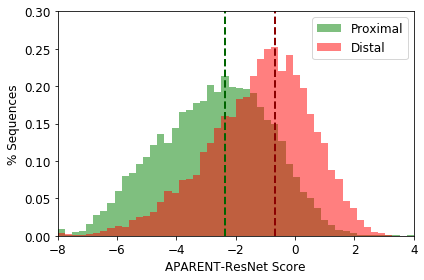

In [4]:
#Proximal-most vs Distal-most PAS scores

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

s_prox = []
s_dist = []
for i in range(s.shape[0]) :
    s_prox.append(s[i, prox_index[i]])
    s_dist.append(s[i, dist_index[i]])

s_prox = np.array(s_prox)
s_dist = np.array(s_dist)

s_min = -8.
s_max = 4.

prox_hist, bin_edges = np.histogram(s_prox, bins=50, range=(s_min, s_max), density=True)
dist_hist, _ = np.histogram(s_dist, bins=50, range=(s_min, s_max), density=True)

bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width / 2.

median_prox = bin_edges[np.argmax(prox_hist)] + bin_width / 2.
median_dist = bin_edges[np.argmax(dist_hist)] + bin_width / 2.

f = plt.figure(figsize=(6, 4))

plt.bar(bin_centers, prox_hist, width=bin_width, color='green', alpha=0.5, label='Proximal')
plt.bar(bin_centers, dist_hist, width=bin_width, color='red', alpha=0.5, label='Distal')

plt.axvline(x=median_prox, linestyle='--', linewidth=2, color='darkgreen')
plt.axvline(x=median_dist, linestyle='--', linewidth=2, color='darkred')

plt.xlim(s_min, s_max)
plt.ylim(0, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT-ResNet Score", fontsize=12)
plt.ylabel("% Sequences", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("polyadb_resnet_prox_vs_dist_hist.png", dpi=300, transparent=True)
plt.savefig("polyadb_resnet_prox_vs_dist_hist.eps")

plt.show()



In [5]:

l_dist = []
l_cumulative_dist = []
for i in range(s.shape[0]) :
    l_dist.append(l[i, dist_index[i]])
    l_cumulative_dist.append(l_cumulative[i, dist_index[i]])

l_dist = np.array(l_dist)
l_cumulative_dist = np.array(l_cumulative_dist)


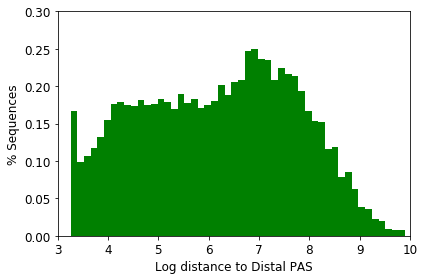

0.08942565902169528
1.296911442250643e-23


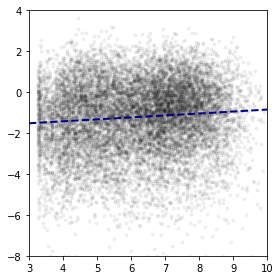

T-test Statistic = -8.075079275001649
T-test P-value = 9.04469115926989e-16


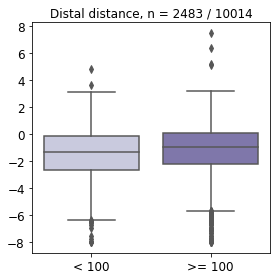

In [6]:

min_l = 3.
max_l = 10.

keep_index = (l_dist >= min_l) & (l_dist < max_l)

f = plt.figure(figsize=(6, 4))

plt.hist(l_dist[keep_index], bins=50, color='green', density=True)

plt.xlim(min_l, max_l)
plt.ylim(0, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Log distance to Distal PAS", fontsize=12)
plt.ylabel("% Sequences", fontsize=12)

plt.tight_layout()

plt.show()

r_val, p_val = spearmanr(l_dist[keep_index], s_dist[keep_index])

print(r_val)
print(p_val)

lr = LinearRegression().fit(l_dist[keep_index][:, None], s_dist[keep_index][:, None])

min_s_fit, max_s_fit = lr.predict(np.array([min_l, max_l])[:, None])

f = plt.figure(figsize=(4, 4))

plt.scatter(l_dist[keep_index], s_dist[keep_index], color='black', s=8, alpha=0.05)

plt.plot([min_l, max_l], [min_s_fit, max_s_fit], linewidth=2, color='darkblue', linestyle='--')

plt.xlim(min_l, max_l)
plt.ylim(-8., 4.)

plt.tight_layout()

plt.show()


distance_cutoff = 100

arr_1 = np.array(s_dist[keep_index][l_dist[keep_index] < np.log(distance_cutoff)])
arr_2 = np.array(s_dist[keep_index][l_dist[keep_index] >= np.log(distance_cutoff)])

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[arr_1, arr_2], palette='Purples')

plt.xticks([0, 1], ['< ' + str(distance_cutoff), '>= ' + str(distance_cutoff)], fontsize=12)
plt.yticks(fontsize=12)

n_1 = arr_1.shape[0]
n_2 = arr_2.shape[0]

stat, p = ttest_ind(arr_1, arr_2, equal_var=False)

print("T-test Statistic = " + str(stat))
print("T-test P-value = " + str(p))

plt.title("Distal distance, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.show()



In [7]:
#Proximal-most vs Distal-most PAS scores

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

s_dists = []
s_dist_means = []
s_dist_medians = []
s_dist_stds = []
for k in range(0, 30) :
    
    s_d = []
    for i in range(s.shape[0]) :
        if k == 0 :
            s_d.append(s[i, dist_index[i] - k])
        elif dist_index[i] - k >= 0 :
            s_d.append(s[i, dist_index[i] - k])
    
    s_dists.append(np.array(s_d))
    
    s_dist_means.append(np.mean(s_dists[-1]))
    s_dist_medians.append(np.median(s_dists[-1]))
    s_dist_stds.append(np.std(s_dists[-1]))

s_dist_means = np.array(s_dist_means)
s_dist_medians = np.array(s_dist_medians)
s_dist_stds = np.array(s_dist_stds)


In [8]:

np.sum(m)


75899.0

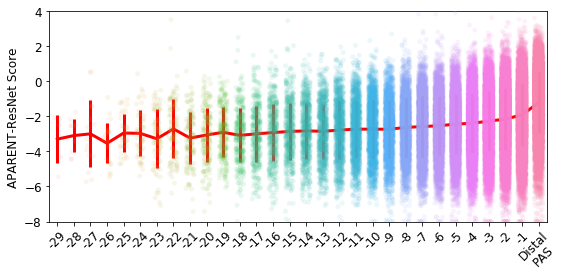

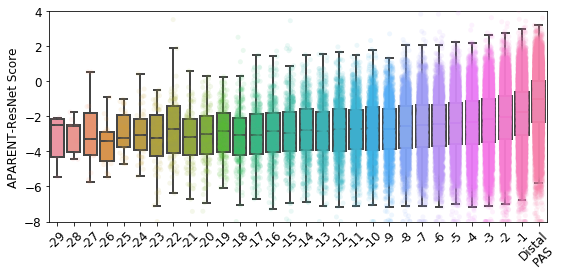

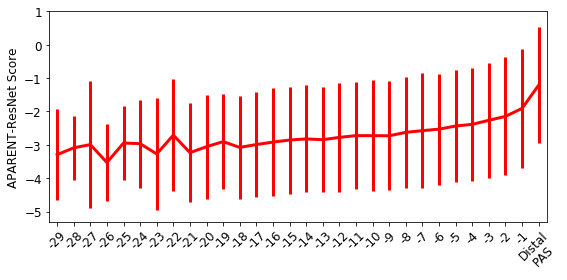

In [8]:

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=s_dists[::-1], alpha=0.1, jitter=0.25)

plt.errorbar(np.arange(30), s_dist_means[::-1], yerr=s_dist_stds[::-1], linewidth=3, color='red', linestyle='-')

plt.xlim(-0.5, 29.5)
plt.ylim(-8., 4.)

plt.xticks(
    np.arange(30),
    ["-" + str(29-j) if j != 29 else "Distal\nPAS" for j in range(30)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.savefig("polyadb_resnet_multi_pas_distrib_with_line.png", dpi=300, transparent=True)
plt.savefig("polyadb_resnet_multi_pas_distrib_with_line.eps")

plt.show()

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=s_dists[::-1], alpha=0.1, jitter=0.25)
sns.boxplot(data=s_dists[::-1], linewidth=2, fliersize=0.)

plt.xlim(-0.5, 29.5)
plt.ylim(-8., 4.)

plt.xticks(
    np.arange(30),
    ["-" + str(29-j) if j != 29 else "Distal\nPAS" for j in range(30)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.savefig("polyadb_resnet_multi_pas_distrib_with_box.png", dpi=300, transparent=True)
plt.savefig("polyadb_resnet_multi_pas_distrib_with_box.eps")

plt.show()

f = plt.figure(figsize=(8, 4))

plt.errorbar(np.arange(30), s_dist_means[::-1], yerr=s_dist_stds[::-1], linewidth=3, color='red', linestyle='-')
#plt.plot(np.arange(30), s_dist_medians[::-1], linewidth=3, color='black', linestyle='-')

plt.xlim(-0.5, 29.5)
plt.ylim(-5.3, 1.)

plt.xticks(
    np.arange(30),
    ["-" + str(29-j) if j != 29 else "Distal\nPAS" for j in range(30)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.savefig("polyadb_resnet_multi_pas_distrib_only_line.png", dpi=300, transparent=True)
plt.savefig("polyadb_resnet_multi_pas_distrib_only_line.eps")

plt.show()
